In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import math
from scipy.integrate import solve_ivp
from scipy.optimize import curve_fit
import numpy as np

In [4]:
df = pd.read_csv("1976-2020-senate.csv")

In [3]:
df

,year,state,state_po,state_fips,state_cen,state_ic,office,district,stage,special,candidate,party_detailed,writein,mode,candidatevotes,totalvotes,unofficial,version,party_simplified
0,1976,ARIZONA,AZ,4,86,61,US SENATE,statewide,gen,False,SAM STEIGER,REPUBLICAN,False,total,321236,741210,False,20210114,REPUBLICAN
1,1976,ARIZONA,AZ,4,86,61,US SENATE,statewide,gen,False,WM. MATHEWS FEIGHAN,INDEPENDENT,False,total,1565,741210,False,20210114,OTHER
2,1976,ARIZONA,AZ,4,86,61,US SENATE,statewide,gen,False,DENNIS DECONCINI,DEMOCRAT,False,total,400334,741210,False,20210114,DEMOCRAT
3,1976,ARIZONA,AZ,4,86,61,US SENATE,statewide,gen,False,ALLAN NORWITZ,LIBERTARIAN,False,total,7310,741210,False,20210114,LIBERTARIAN
4,1976,ARIZONA,AZ,4,86,61,US SENATE,statewide,gen,False,BOB FIELD,INDEPENDENT,False,total,10765,741210,False,20210114,OTHER
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3625,2020,WYOMING,WY,56,83,68,US SENATE,statewide,gen,False,UNDER VOTES,NaN,False,total,6401,278503,False,20210114,OTHER
3626,2021,GEORGIA,GA,13,58,44,US SENATE,statewide,runoff,True,KELLY LOEFFLER,REPUBLICAN,False,total,2194848,4483294,True,20210114,REPUBLICAN
3627,2021,GEORGIA,GA,13,58,44,US SENATE,statewide,runoff,True,RAPHAEL WARNOCK,DEMOCRAT,False,total,2288446,4483294,True,20210114,DEMOCRAT
3628,2021,GEORGIA,GA,13,58,44,US SENATE,statewide,runoff,False,DAVID A. PERDUE,REPUBLICAN,False,total,2213979,4483241,True,20210114,REPUBLICAN


In [7]:
selected_states = ['NEW HAMPSHIRE', 'NORTH CAROLINA', 'OKLAHOMA', 'OREGON', 'SOUTH CAROLINA', 'SOUTH DAKOTA']
filtered_df = df[df['state'].isin(selected_states)]

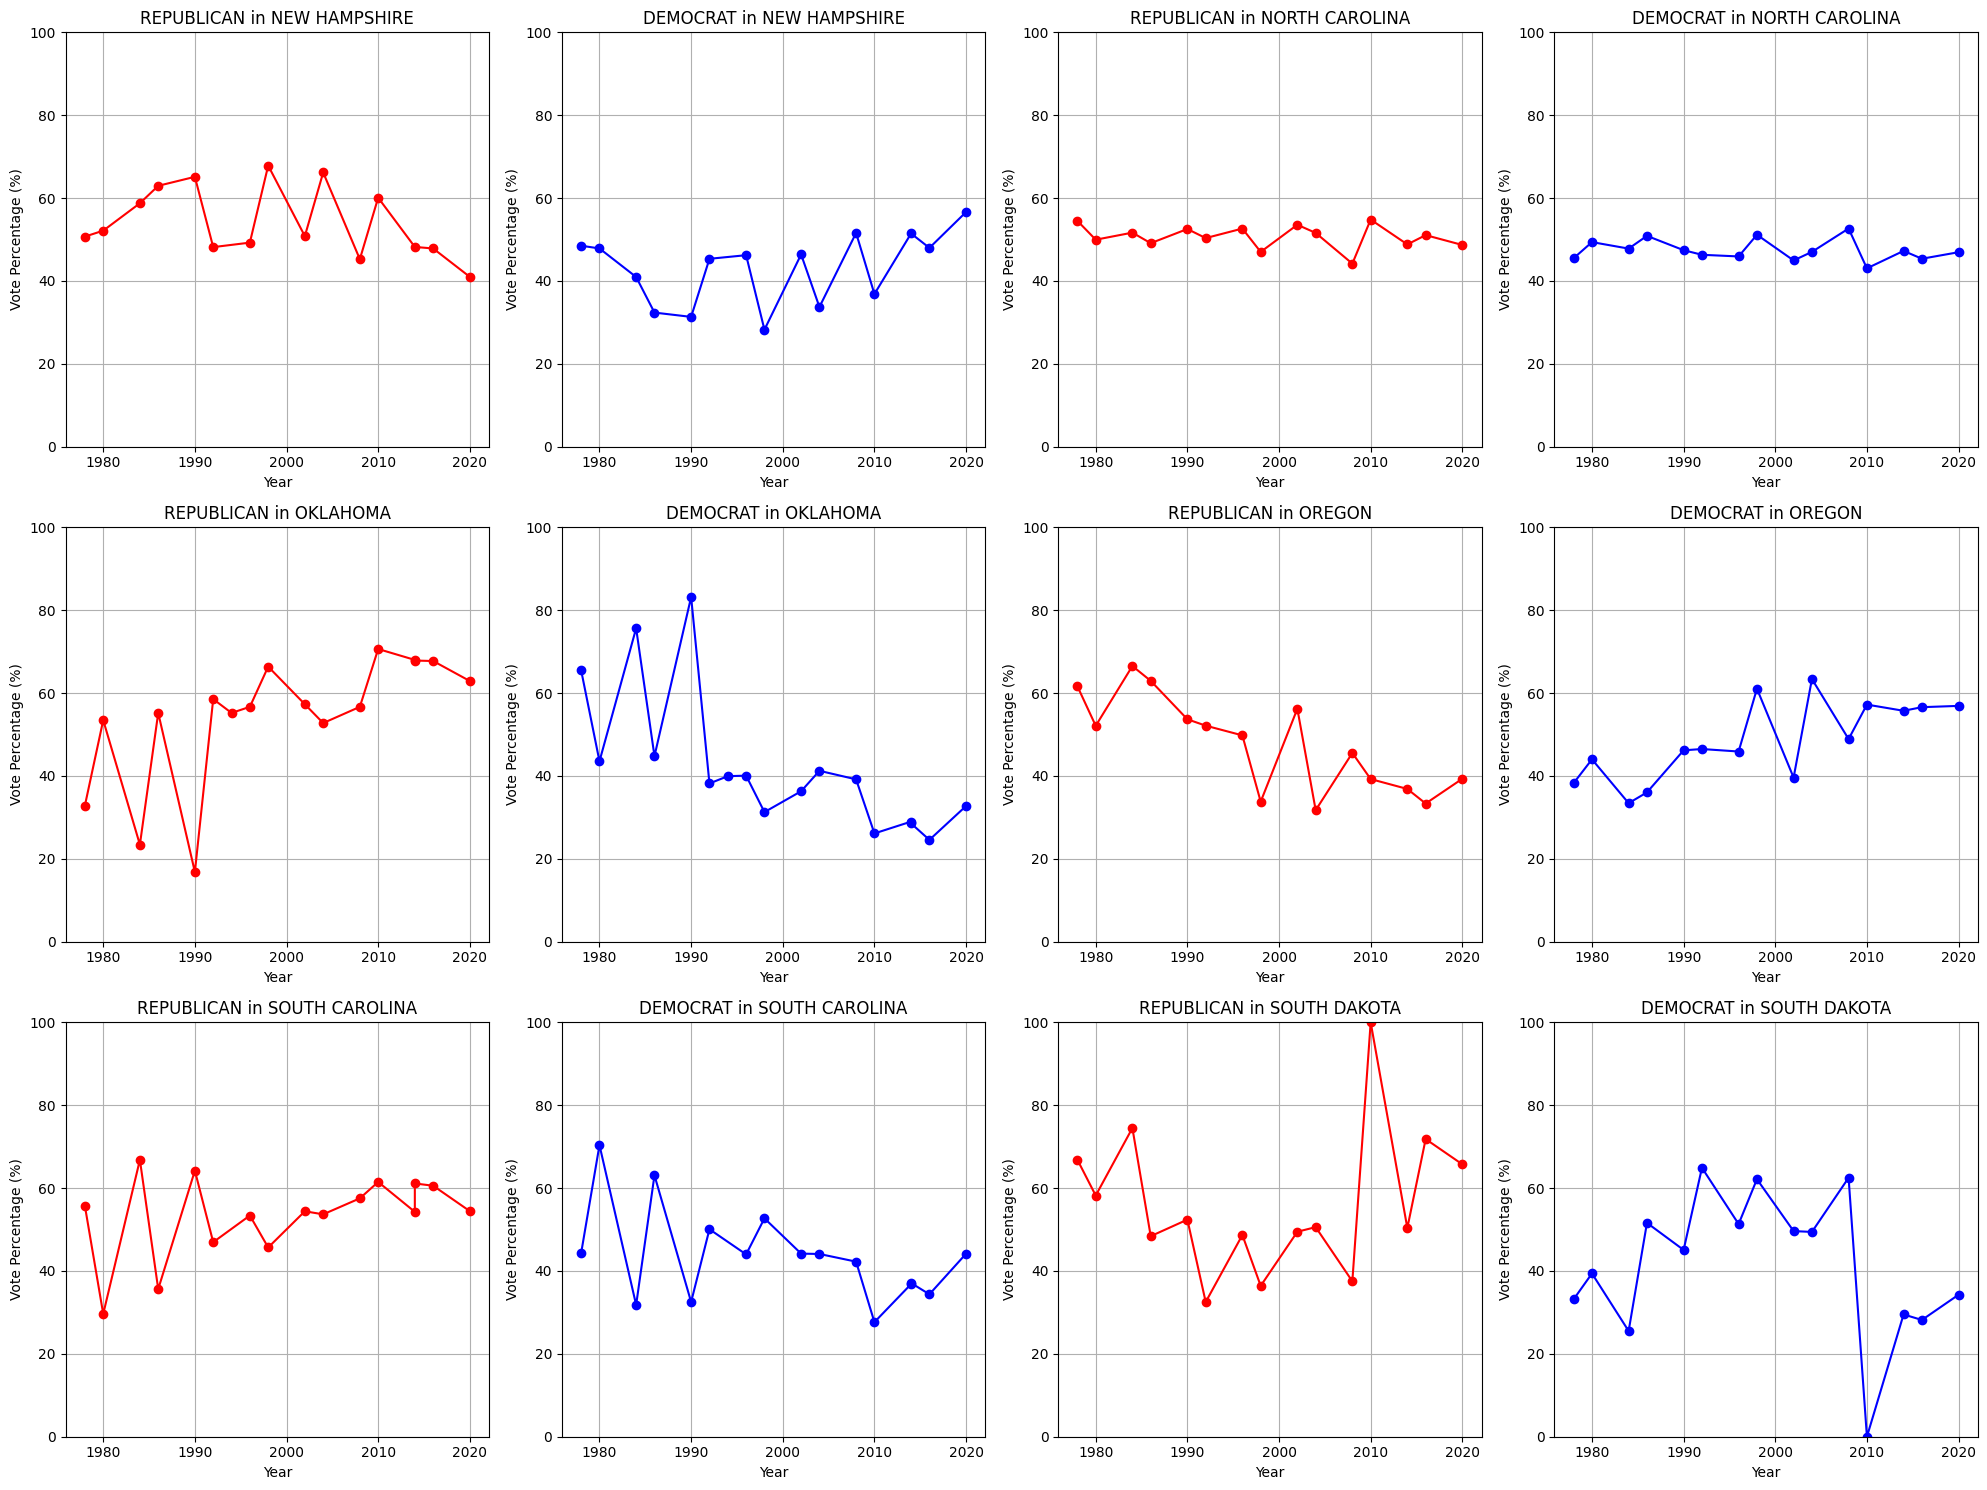

In [8]:
states = filtered_df['state'].unique()
party_order = ['REPUBLICAN', 'DEMOCRAT']
colors = {'REPUBLICAN': 'red', 'DEMOCRAT': 'blue'} # BONUS 
df_dict = {}
num_plots = len(states) * len(party_order)
cols = 4  # Number of columns in the grid
rows = math.ceil(num_plots / cols)

fig, axes = plt.subplots(rows, cols, figsize=(20, rows * 5))
axes = axes.flatten()

plot_index = 0
for state in states:
    for party in party_order:
        state_party_data = df[(df['state'] == state) & (df['party_simplified'] == party)]
        state_party_data = state_party_data[state_party_data['writein'] == False]
        df_dict[(state, party)] = state_party_data
        if not state_party_data.empty:
            ax = axes[plot_index]
            ax.plot(state_party_data['year'], state_party_data['candidatevotes'] / state_party_data['totalvotes'] * 100, marker='o', color=colors[party])
            ax.set_title(f'{party} in {state}')
            ax.set_xlabel('Year')
            ax.set_ylabel('Vote Percentage (%)')
            ax.set_ylim(0, 100)
            ax.grid(True)
            plot_index += 1

# Hide unused subplots
for i in range(plot_index, len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

# Pearson Coefficient

In [9]:
year1 = df_dict[('NEW HAMPSHIRE', 'REPUBLICAN')]['year'].values
votes1 = df_dict[('NEW HAMPSHIRE', 'REPUBLICAN')]['candidatevotes'].values
total_votes1 = df_dict[('NEW HAMPSHIRE', 'REPUBLICAN')]['totalvotes'].values
vote_percentage1 = votes1 / total_votes1

year = df_dict[('OREGON', 'REPUBLICAN')]['year'].values
votes = df_dict[('OREGON', 'REPUBLICAN')]['candidatevotes'].values
total_votes = df_dict[('OREGON', 'REPUBLICAN')]['totalvotes'].values
vote_percentage = votes / total_votes

correlation = np.corrcoef(vote_percentage, vote_percentage1)[0, 1]
print("Pearson Correlation:", correlation)

Pearson Correlation: 0.01222907607251956


# Fitting with Least Squares

In [6]:
cols = ['year', 'candidatevotes', 'totalvotes']
df_dict[('NEW HAMPSHIRE', 'REPUBLICAN')][cols]

,year,candidatevotes,totalvotes
221,1978,133745,263760
346,1980,195559,375060
607,1984,225828,384369
719,1986,154090,244735
956,1990,189792,291393
1100,1992,249591,518170
1415,1996,242257,491873
1568,1998,213477,314696
1905,2002,227229,447135
2059,2004,434847,657086


In [7]:
def sir_model(t, y, beta, gamma):
    '''' y is tuple with 
    (S, I, R) - > (Voters (infuencible), Opioniated voters (voter percentage for chosen candidate), Recovered (Voters who change sides) 
    
    '''
    S, I, R = y
    dSdt = -beta * S * I # It can go both ways ? 
    dIdt = beta * S * I - gamma * I # what is the mechanism for this. What is gamma a function of ? 
    dRdt = gamma * I # potenitally, beta and gamma are funcitons of time ? 
    return [dSdt, dIdt, dRdt]

In [8]:
def fit_sir_model(t, beta, gamma, S0, I0, R0):
    '''What is the return value?'''
    sol = solve_ivp(sir_model, [t[0], t[-1]], [S0, I0, R0], t_eval=t, args=(beta, gamma))
    return sol.y[1] # returns S, I, R as they change wrt time. y[1] gives I 

In [9]:
year = df_dict[('NEW HAMPSHIRE', 'REPUBLICAN')]['year'].values
votes = df_dict[('NEW HAMPSHIRE', 'REPUBLICAN')]['candidatevotes'].values
total_votes = df_dict[('NEW HAMPSHIRE', 'REPUBLICAN')]['totalvotes'].values
vote_percentage = votes / total_votes
I0 = vote_percentage[0]
S0 = 1 - I0
R0 = 0

# fit the curve provided initial guess. 0.1 each | Gives local optimum
params, covariance = curve_fit(fit_sir_model, year, vote_percentage, p0=[0.1, 0.1, S0, I0, R0], bounds=(0, [1, 1, 1, 1, 1]))
beta, gamma = params[:2]
print(f"Fitted parameters: beta={beta}, gamma={gamma}")

Fitted parameters: beta=0.05437961621978311, gamma=0.03446399192118356


In [10]:
fitted_voter_percentage = fit_sir_model(year, *params)

In [11]:
split_index = int(0.8 * len(year))

X_train, X_test = year[:split_index], year[split_index:]
y_train, y_test = vote_percentage[:split_index], vote_percentage[split_index:]
params, covariance = curve_fit(fit_sir_model, X_train, y_train, p0=[0.1, 0.1, S0, I0, R0], bounds=(0, [1, 1, 1, 1, 1]))
beta, gamma = params[:2]
print(f"Fitted parameters: beta={beta}, gamma={gamma}")
test_fit = (fit_sir_model(year, *params))


Fitted parameters: beta=0.5672019667303213, gamma=0.0036563196181867703


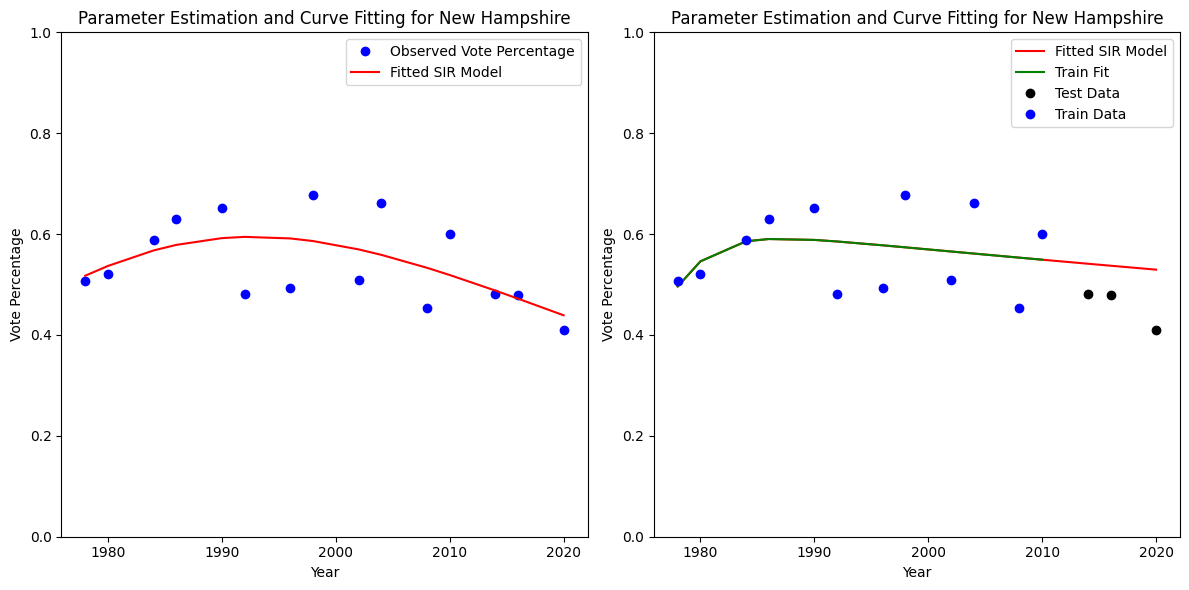

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# First plot
axes[0].plot(year, vote_percentage, 'bo', label='Observed Vote Percentage')
axes[0].plot(year, fitted_voter_percentage, 'r-', label='Fitted SIR Model')
axes[0].set_xlabel('Year')
axes[0].set_ylabel('Vote Percentage')
axes[0].set_ylim(0, 1)
axes[0].legend()
axes[0].set_title('Parameter Estimation and Curve Fitting for New Hampshire')

# Second plot
axes[1].plot(year, test_fit, 'r-', label='Fitted SIR Model')
axes[1].plot(X_train, fit_sir_model(X_train, *params), 'g-', label='Train Fit')
axes[1].plot(X_test, y_test, 'ko', label='Test Data')
axes[1].plot(X_train, y_train, 'bo', label='Train Data')
axes[1].set_xlabel('Year')
axes[1].set_ylabel('Vote Percentage')
axes[1].set_ylim(0, 1)
axes[1].legend()
axes[1].set_title('Parameter Estimation and Curve Fitting for New Hampshire')

# Adjust layout for better spacing
plt.tight_layout()

# Show the plots
plt.show()

## TO DO
- clean the data frame to get more data. 
- Train-test split | Cross Validate
- Get optimum parameters for different guesses. 
- Can try different estimations
- ADD MORE REALISTIC PARAMETERS TO THE MODEL 

In [13]:
year = df_dict[('OREGON', 'REPUBLICAN')]['year'].values
votes = df_dict[('OREGON', 'REPUBLICAN')]['candidatevotes'].values
total_votes = df_dict[('OREGON', 'REPUBLICAN')]['totalvotes'].values
vote_percentage = votes / total_votes
split_index = int(0.8 * len(year))

X_train, X_test = year[:split_index], year[split_index:]
y_train, y_test = vote_percentage[:split_index], vote_percentage[split_index:]
I0 = vote_percentage[0]
S0 = 1 - I0
R0 = 0

# fit the curve provided initial guess. 0.1 each | Gives local optimum
params, covariance = curve_fit(fit_sir_model, X_train, y_train, p0=[0.1, 0.1, S0, I0, R0], bounds=(0, [1, 1, 1, 1, 1]))
beta, gamma = params[:2]
test_fit = (fit_sir_model(year, *params))
print(f"Fitted parameters: beta={beta}, gamma={gamma}")

Fitted parameters: beta=0.4666418583578674, gamma=0.01909952616941452


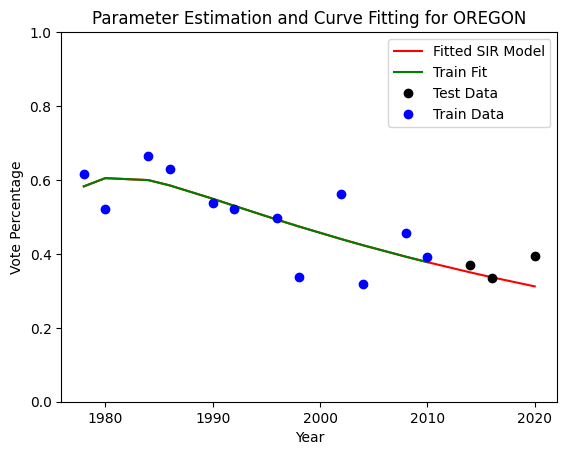

In [14]:
plt.plot(year, test_fit, 'r-', label='Fitted SIR Model')
plt.plot(X_train, fit_sir_model(X_train, *params), 'g-', label='Train Fit')
plt.plot(X_test, y_test, 'ko', label='Test Data')
plt.plot(X_train, y_train, 'bo', label='Train Data')
plt.xlabel('Year')
plt.ylabel('Vote Percentage')
plt.ylim(0, 1)
plt.legend()
plt.title('Parameter Estimation and Curve Fitting for OREGON')
plt.show()

# Evolutionary algorithm

In [17]:
from deap import base, creator, tools, algorithms
import numpy as np
from scipy.integrate import odeint
import random

In [18]:
def sir_model1(y, t, beta, gamma, N):
    S, I, R = y
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - gamma * I
    dRdt = gamma * I
    return [dSdt, dIdt, dRdt]

In [19]:
def fitness_function(params, t, data_I, N):
    beta, gamma = params
    S0, I0, R0 = N - data_I[0], data_I[0], 0  # Assume S0 is total population minus initial I
    y0 = S0, I0, R0

    # Solve ODEs
    sol = odeint(sir_model1, y0, t, args=(beta, gamma, N))

    # Compute the squared error for the infected population
    I_model = sol[:, 1]  # Extract the infected population from the model
    error_I = np.sum((I_model - data_I) ** 2)

    return error_I,

In [20]:
def run_ga(data_I, t, N):
    # Define the problem as a minimization problem
    creator.create("FitnessMin", base.Fitness, weights=(-1.0,))  # Minimize fitness
    creator.create("Individual", list, fitness=creator.FitnessMin)

    # Initialize the individual and population
    def create_individual():
        return [random.uniform(0, 1) for _ in range(2)]  # Beta and Gamma values

    # Register the components for the GA
    toolbox = base.Toolbox()
    toolbox.register("individual", tools.initIterate, creator.Individual, create_individual)
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)
    toolbox.register("mate", tools.cxBlend, alpha=0.5)
    toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=0.1, indpb=0.2)
    toolbox.register("select", tools.selTournament, tournsize=3)
    toolbox.register("evaluate", fitness_function, t=t, data_I=data_I, N=N)

    # Create the population
    population = toolbox.population(n=50)

    # Set the parameters for the genetic algorithm
    ngen = 100  # number of generations
    cxpb = 0.7  # probability of mating
    mutpb = 0.2  # probability of mutation

    # Run the genetic algorithm
    algorithms.eaSimple(population, toolbox, cxpb=cxpb, mutpb=mutpb, ngen=ngen, 
                        stats=None, halloffame=None, verbose=True)

    # Extract the best individual (solution)
    best_individual = tools.selBest(population, 1)[0]
    return best_individual

In [21]:
N = 10000
best_params = run_ga(vote_percentage, year, N)
beta, gamma = best_params
print(f"Best parameters from GA: beta={beta}, gamma={gamma}")
ea_fit = (fit_sir_model(year, *params))

gen	nevals
0  	50    
1  	41    
2  	35    
3  	35    
4  	42    
5  	38    
6  	41    
7  	32    
8  	34    
9  	39    
10 	33    
11 	33    
12 	45    
13 	36    
14 	42    
15 	38    
16 	41    
17 	46    
18 	42    
19 	36    
20 	40    
21 	43    
22 	44    
23 	35    
24 	39    
25 	40    
26 	32    
27 	34    
28 	41    
29 	35    
30 	41    
31 	34    
32 	38    
33 	39    
34 	39    
35 	44    
36 	33    
37 	33    
38 	32    
39 	36    
40 	30    
41 	37    
42 	36    
43 	36    
44 	38    
45 	37    
46 	36    
47 	46    
48 	45    
49 	47    
50 	35    
51 	33    
52 	37    
53 	39    
54 	32    
55 	34    
56 	40    
57 	30    
58 	43    
59 	42    
60 	38    
61 	38    
62 	44    
63 	44    
64 	45    
65 	45    
66 	40    
67 	37    
68 	36    
69 	37    
70 	29    
71 	37    
72 	35    
73 	42    
74 	36    
75 	39    
76 	46    
77 	35    
78 	43    
79 	36    
80 	44    
81 	34    
82 	35    
83 	34    
84 	44    
85 	35    
86 	39    
87 	40    
88 	37    
89 	35    

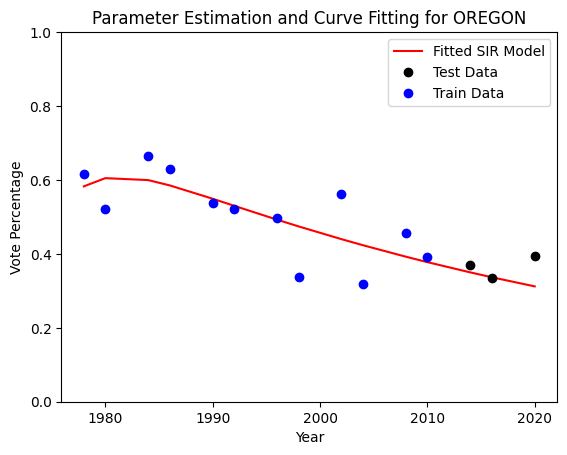

In [22]:
plt.plot(year, ea_fit, 'r-', label='Fitted SIR Model')
# plt.plot(X_train, fit_sir_model(X_train, *params), 'g-', label='Train Fit')
plt.plot(X_test, y_test, 'ko', label='Test Data')
plt.plot(X_train, y_train, 'bo', label='Train Data')
plt.xlabel('Year')
plt.ylabel('Vote Percentage')
plt.ylim(0, 1)
plt.legend()
plt.title('Parameter Estimation and Curve Fitting for OREGON')
plt.show()

# Implementing sliding window parameter fitting

In [23]:
def loss(params, t, R_data, I0=0.01):
    beta, gamma = params
    S0 = 1 - I0
    y0 = [S0, I0, 0.0]
    sol = odeint(sir_model1, y0, t, args=(beta, gamma))
    R_pred = sol[:, 2]
    return np.mean((R_pred - R_data) ** 2)

In [30]:
year = df_dict[('OREGON', 'REPUBLICAN')]['year'].values
votes = df_dict[('OREGON', 'REPUBLICAN')]['candidatevotes'].values
total_votes = df_dict[('OREGON', 'REPUBLICAN')]['totalvotes'].values
vote_percentage = votes / total_votes
M = 4
window_length  = int(len(year / M))
beta_array = np.zeros(len(year)-M+1)
gamma_array = np.zeros(len(year)-M+1)
test_fit_array = np.zeros((len(year)-M+1, M))
for i in range(len(year)-M+1):
    I0 = vote_percentage[i]
    S0 = 1 - I0
    R0 = 0
    params, covariance = curve_fit(fit_sir_model, year[i:i+M], vote_percentage[i:i+M], p0=[0.1, 0.1, S0, I0, R0], bounds=(0, [1, 1, 1, 1, 1]))
    beta_array[i], gamma_array[i] = params[:2]
    test_fit_array[i, :] = fit_sir_model(year[i:i+M], *params)


C:\Users\alanr\AppData\Local\Temp\ipykernel_16268\542416742.py:14: OptimizeWarning: Covariance of the parameters could not be estimated
  params, covariance = curve_fit(fit_sir_model, year[i:i+M], vote_percentage[i:i+M], p0=[0.1, 0.1, S0, I0, R0], bounds=(0, [1, 1, 1, 1, 1]))


In [ ]:
test_fit = (fit_sir_model(year, *params))


array([3.14954444e-06, 4.33047818e-02, 3.25344535e-02, 2.43689544e-02,
       1.96595066e-01, 6.60761265e-15, 1.23089454e-01, 3.18883215e-02,
       2.49587226e-02, 4.99794104e-02, 3.50177545e-02, 1.71301926e-03])

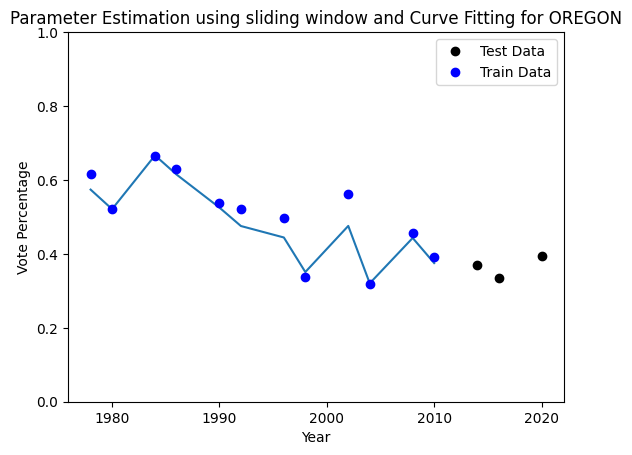

In [46]:
new = test_fit_array.T
plt.plot(year[:12], new[0])
plt.plot(X_test, y_test, 'ko', label='Test Data')
plt.plot(X_train, y_train, 'bo', label='Train Data')
plt.xlabel('Year')
plt.ylabel('Vote Percentage')
plt.ylim(0, 1)
plt.legend()
plt.title('Parameter Estimation using sliding window and Curve Fitting for OREGON')
plt.show()